# Predicting M dwarf rotation periods using linear regression.

$$P_\mathrm{rot} = w.A $$
$$P_\mathrm{rot} = w_0 \mathrm{Nfl} + w_1 \mathrm{Nfl_{68}} ... + w_x \mathrm{Nfl~Nfl_{68}} + ... $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [2]:
dav = pd.read_csv("davenport2018.csv", skiprows=61, delimiter=";")
dav.head()

,KIC,g-i,Mass,Prot,Nfl,Nfl68,Lfl/Lkp,e_Lfl/Lkp,alpha,beta,M14,C16,Simbad,_RA,_DE
0,10000490,NaN,1.38,NaN,241,45,0.000043,1.480000e-07,-0.55,18.84,0,2,Simbad,286.55600,46.95734
1,10001145,0.013,1.60,NaN,271,61,0.000052,1.430000e-08,-1.41,48.85,0,2,Simbad,286.94516,46.90519
2,10001154,1.404,0.72,NaN,118,115,0.000014,1.640000e-08,-0.57,17.35,0,1,Simbad,286.94800,46.91293
3,10001167,1.151,0.77,NaN,147,131,0.000072,2.670000e-08,-0.42,12.79,0,0,Simbad,286.95575,46.93662
4,10002792,1.393,0.73,1.165,225,210,0.000410,3.380000e-07,-0.52,16.82,1,0,Simbad,287.86722,46.98308


In [3]:
import astropy.utils as au
from astropy.io import fits

gaia_url = "kepler_dr2_1arcsec.fits"

with fits.open(gaia_url) as data:
    gaia = pd.DataFrame(data[1].data, dtype="float64")

In [4]:
df1 = pd.merge(dav, gaia, left_on="KIC", right_on="kepid", how="inner")

In [5]:
print(np.shape(df1))

(3994, 116)


Calculate abs mag and colour.

In [6]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(abs(D)) + 5

df1["abs_G"] = m_to_M(df1.phot_g_mean_mag.values, 1./df1.parallax.values)
df1["bprp"] = df1.phot_bp_mean_mag.values - df1.phot_rp_mean_mag.values

Mask out missing data.

In [7]:
features = [df1["g-i"], df1["Mass"], df1["Nfl"], df1["Nfl68"], df1["Lfl/Lkp"], df1["alpha"], df1["beta"],
            df1["ra"], df1["dec"], df1["parallax"], 1./df1["parallax"], df1["abs_G"], df1["bprp"],
            df1["pmra"], df1["pmdec"], df1["Prot"]]

m = np.isfinite(df1["g-i"].values)
for f in features[1:]:
    m &= np.isfinite(f.values)
    
df = df1.iloc[m]
print(np.shape(df), np.shape(df1))

(391, 118) (3994, 118)


Linear least squares:

In [8]:
def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

Define the y-vector (what you want to predict).

In [9]:
y = df.Prot.values

Define the X matrix (the data you're using to predict y).

In [10]:
from itertools import combinations_with_replacement

args = df["g-i"], df["Mass"], df["Nfl"], df["Nfl68"], df["Lfl/Lkp"], df["alpha"], df["beta"], \
    df["ra"], df["dec"], df["parallax"], 1./df["parallax"], df["abs_G"], df["bprp"], df["pmra"], df["pmdec"]
X = list(args)
for a, b in combinations_with_replacement(args, 2):
    X.append(a * b)
X = np.array(X).T
print(np.shape(X), len(args))

(391, 135) 15


Shuffle X and y and select training and testing sets.

In [11]:
# Define the number of training and validating stars.
Ntrain = 2000

# Choose stars at random and split.
shuffle_inds = np.arange(len(y))
np.random.shuffle(shuffle_inds)
train_inds = shuffle_inds[:Ntrain]
test_inds = shuffle_inds[Ntrain:]
y_train, X_train = y[train_inds], X[train_inds, :]
y_test, X_test = y[test_inds], X[test_inds, :]

Solve for the weight vector.

In [12]:
weights = train(y_train, X_train)

Compute the predicted y-values.

In [13]:
A = np.concatenate((np.ones((len(X_train), 1)), X_train), axis=1)
y_predict = np.dot(weights.T, A.T)

Plot the prediction for the training set.

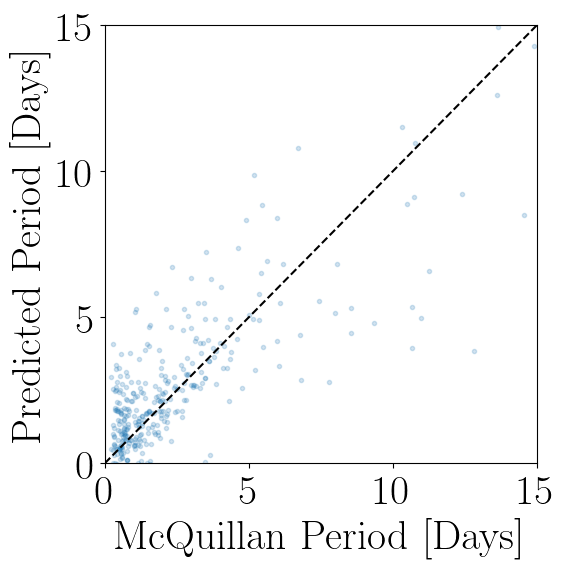

In [14]:
xs = np.linspace(0, 15, 100)

plt.figure(figsize=(6, 6), dpi=100)
plt.plot(y_train, y_predict.T, ".", alpha=.2)
plt.plot(xs, xs, "k--")
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.xlabel("$\mathrm{McQuillan~Period~[Days]}$")
plt.ylabel("$\mathrm{Predicted~Period~[Days]}$")
plt.subplots_adjust(left=.18, bottom=.15)